In [1]:
import torch
import numpy as np
from models.v2pca import *
from scipy.io import loadmat
import matplotlib.pyplot as plt
from config import *
from models.genutils import *
from sklearn.feature_extraction.image import extract_patches_2d
import h5py

(688, 512, 512)
1.0 0.0
3.304715 -3.1593707


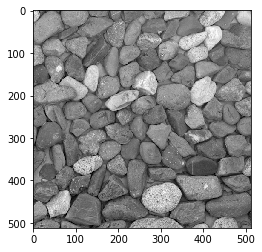

In [31]:
ims =h5py.File('./data/cropped512-gray-jpg.h5', 'r')['dat']
print(ims.shape)
ims0 = ims[0]
print(ims0.max(), ims0.min())
ims0 = (ims0 - ims0.mean())/ims0.std()
print(ims0.max(), ims0.min())
plt.imshow(ims0, cmap='gray')

In [5]:
#data loading from matfile
data_path = './data/bundleClassify_64_12_1.mat'
matdata = loadmat(data_path)
#pcadata = loadmat('./data.mat')
'''
mat file contains nested structs of following structure
data
    input (input data images and coefficients from steerably pyramid output)
        imgSample (sample large images that patches are taken from)
        imgSampleSmall (resized version of imgSample to 64x64)
        dataMatrix (classification data matrix)
        dataClassificationGroup
        dataTextureStatistics
        dataImg (sampled image patches from original imgSample images)
        dataScrambledImg (sampled image patches but phase scrambled)
        
    f (component filter data)
        filter
            coeff
            coeffPermutation
            coeffRecon
        coeffWeights
        coeffIndex
        coeffTransferSet
        componentResponseMatrix
        componentError_l
        componentError_q
    spyr (name of steerable pyramid filters used from simoncelli code)
        'sp3Filters'
'''
large_ims = np.array(matdata['data'][0][0]['input'][0][0]['imgSample'])
print(large_ims.shape)
num_ims = 12
imsize=64
impatches = np.empty((0,imsize*imsize),float)
for i in range(num_ims):
    ims = extract_patches_2d(large_ims[i,0,:,:].reshape([256,256]),(64,64), max_patches = 800)
    ims = np.reshape(ims, [ims.shape[0], ims.shape[1]*ims.shape[1]])
    normed_ims = (ims-ims.mean(axis=1, keepdims=1))/ims.std(axis=1, keepdims=1)
    impatches = np.vstack((impatches, normed_ims))

np.random.shuffle(impatches)

print(impatches.shape)
print(impatches.mean(axis=1)[2000:2010])
print(impatches.std(axis=1)[2000:2010])
impatches = impatches.reshape(-1,imsize,imsize)
print(impatches.shape)

(12, 2, 256, 256)
(9600, 4096)
[-1.86656246e-15 -1.59594560e-16  3.74700271e-16 -3.19189120e-16
 -1.09634524e-15  2.08166817e-16  3.33066907e-16  4.16333634e-17
  3.05311332e-16  6.38378239e-16]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(9600, 64, 64)


In [ ]:
indices = np.random.randint(20000,size=5)
print(indices)
for ind in indices:
    plt.figure()
    plt.imshow(impatches[ind,:,:], cmap='gray')

#plt.figure()
#plt.imshow(large_ims[3,0,:,:].reshape([256,256]), cmap='gray')

In [ ]:
impatch = np.array(matdata['data'][0][0]['input'][0][0]['dataImg'])
window = torch.tensor(np.array(matdata['data'][0][0]['f'][0][0]['coeffWeights']), device=device, dtype=dtype).to(device)
#pcaMat = torch.tensor(np.array(pcadata['pcadata'])).to(device)
im = impatch[:,:,:]
print(im.shape)
print(im.min(), im.max())


In [3]:
network1 = V2PCA(imgSize=impatches.shape[1], K=4, N=2, nonlin='quadratic', window = None, pcaMat = None, ret_pyr = False, ncomp=32)

In [4]:
x = impatches.reshape([impatches.shape[0],1,impatches.shape[1],impatches.shape[2]])
x = torch.tensor(x, requires_grad=True, dtype=dtype).to(device)
coeff = network1(x)
#from scipy.io import savemat
#a = {}
#a['pyrdata'] = pyr.data.cpu().numpy()
#savemat('pyrdata', a)

In [5]:
torch.cuda.empty_cache()

In [ ]:

coeffnump = coeff.data.cpu().numpy()
'''
coeffsmall = np.zeros((504,3944))
for i in range(coeffsmall.shape[0]):
    row = coeffnump[i,:]
    coeffsmall[i,:] = row[np.nonzero(row)]
'''
print(coeff.size())


def ZCA(X):
    X_mean = torch.mean(X,1, True)
    X = X - X_mean.expand_as(X)
    cov = torch.mm(torch.t(X),X)/(X.shape[0]-1)
    print("Computing svd...")
    U,S,V = torch.svd(cov)
    print("Computing zcamat...")
    zcamat = torch.mm(U, torch.mm(torch.diag(1/torch.sqrt(S+1e-5)), torch.t(U)))
    return zcamat

def PCA(X):
    X_mean = torch.mean(X,1,True)
    X = X - X_mean.expand_as(X)
    
V = ZCAnump(coeffnump)
#print(U.shape, V.shape)
pcamat = V.data.cpu().numpy()
print(pcamat.shape)
from scipy.io import savemat
a = {}
#a['pcadata'] = A_
a['pcadata'] = pcamat[:,0:32]
savemat('data', a)

torch.Size([8928, 24832])
Computing svd...


In [ ]:
res = torch.mm(coeff, V)
np.argmax(res[:,2].data.cpu().numpy())


In [ ]:
network2 = V2PCA(imgSize=im.shape[1], K=4, N=2, nonlin='quadratic', window=window, pcaMat = pcaMat, ncomp=32)

In [ ]:
from torch.optim import SGD
x = im[16,:,:].reshape([1,1,im.shape[1],im.shape[2]])
x = torch.Tensor(x)
x = x.cuda()
x = Variable( x, requires_grad=True ) 

def run_grad_op(model, image):
    imagelist = []
    optimizer = SGD([image],lr=6)
    for i in range(5):
        def closure():
            #optimizer.zero_grad()
            output = network2(image)
            loss = output[0,2]
            loss.backward()
            return loss
        loss=optimizer.step(closure)
        imagelist.append(x.clone())
    return imagelist

outputim = run_grad_op(network2, x)

In [ ]:
def window_im(xorig, win):
    new_im = np.multiply(xorig.reshape([4096,1]), win[4096:8192].data.cpu().numpy())
    return new_im.reshape([64,64])

xwin = window_im(im[16,:,:], window)
plt.figure()
plt.imshow(xwin.reshape([64,64]), cmap='gray')
plt.axis('off')

In [ ]:
for i in range(len(outputim)):
    plt.figure()
    outputim2 = outputim[i].data.cpu().numpy().reshape([64,64])
    outputwin = window_im(outputim2, window)
    plt.imshow(outputwin, cmap='gray')
    plt.axis('off')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
def make_ticklabels_invisible(fig):
    for i, ax in enumerate(fig.axes):
        ax.tick_params(labelbottom=False, labelleft=False)
f = plt.figure(figsize=(10,8))
K = 4
nR = int(np.ceil(K/2))
nC = K+1-H
print(W,H)
gs0 = gridspec.GridSpec(nR, nC)
gs0.update(wspace=0.025, hspace=0.025) # set the spacing between axes. 

img = y[1].data.select(0,0).select(0,0)           
img = img.view(-1, img.size(-2), img.size(-1) )
img2 = y[2].data.select(0,0).select(0,0)
img2 = img2.view(-1, img.size(-2), img.size(-1))

for i in range(img.size(0)):
    if i < H:
        print(i, W-1)
        loc = gs0[i,-1]
    else:
        print(-1, W-i)
        loc = gs0[-1,W-i]
    ax1 = plt.Subplot(f, loc)
    ax1 = f.add_subplot(ax1)
    im = img[i]
    scale=127.5/max(im.max(), -im.min())
    im =im.mul(scale).add(127.5)
    ax1.imshow(im, cmap='gray')

N=2
for k in range(N):
    inner_grid = gridspec.GridSpecFromSubplotSpec(3, 3,
            subplot_spec=outer_grid[i], wspace=0.0, hspace=0.0)


make_ticklabels_invisible(f)
'''
for i in range()
gs00 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs0[0])

ax1 = plt.Subplot(f, gs00[-1, -1])
f.add_subplot(ax1)
ax2 = plt.Subplot(f, gs00[-1, -2])
f.add_subplot(ax2)
ax3 = plt.Subplot(f, gs00[-1, 0])
f.add_subplot(ax3)
make_ticklabels_invisible(f)'''


In [ ]:
len(y)-

In [ ]:


fig.show()
from PIL import Image
img = y[1].data.select(0,0).select(0,0)           
img = img.view(-1, img.size(-2), img.size(-1) )
print( i, img.size() )
for j in range(img.size(0)):
    plt.figure()
    plt.imshow(img[j], cmap='gray')